In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, InceptionV3, MobileNetV2
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 5
CHANNELS = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Potato_Leaf_disease",
    shuffle=True,
    image_size= (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Early_Blight', 'Healthy', 'Late_Blight']

In [5]:
len(dataset)

68

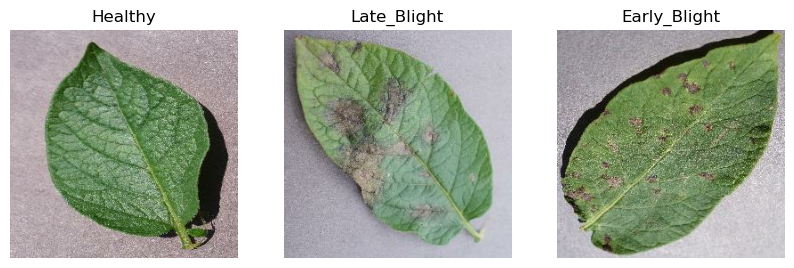

In [6]:
def visualize_dataset(dataset, class_names):
    plt.figure(figsize=(10, 10))
    class_found = {class_name: False for class_name in class_names}
    for images, labels in dataset:
        for i in range(len(labels)):
            class_name = class_names[labels[i]]
            if not class_found[class_name]:
                ax = plt.subplot(1, len(class_names), list(class_found.values()).count(False))
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(class_name)
                plt.axis("off")
                class_found[class_name] = True
            if all(class_found.values()):
                break
        if all(class_found.values()):
            break
    plt.show()

# Visualize the dataset
visualize_dataset(dataset, class_names)

In [7]:
for image_batch, label_batch in dataset.take(1):
    
    
    print(image_batch[0].shape)

(256, 256, 3)


In [8]:
def dataset_partitions(ds, train_split=0.7, val_split=0.2, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = ds_size - train_size - val_size
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
     
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size).take(test_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = dataset_partitions(dataset)

In [10]:
len(train_ds)

47

In [11]:
len(val_ds)

13

In [12]:
len(test_ds)

8

In [13]:
train_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
# scale the image into 1 to 255

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [15]:
# data augmentation : It is very helpfull for better accuracy, it will detect and transform all the 
# type of images when it is rotated or different filter.

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2), 
])

In [20]:
vgg16_base = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), include_top=False, weights='imagenet')
vgg16_base.trainable = False  # Freeze the convolutional base

vgg16_model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    vgg16_base,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

vgg16_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

vgg16_history = vgg16_model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds)

vgg16_scores = vgg16_model.evaluate(test_ds)
print(f"VGG16 Test Accuracy: {vgg16_scores[1] * 100:.2f}%\n")

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - accuracy: 0.6575 - loss: 1.2824 - val_accuracy: 0.8798 - val_loss: 0.2611
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 169s 4s/step - accuracy: 0.9166 - loss: 0.2095 - val_accuracy: 0.9423 - val_loss: 0.1566
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - accuracy: 0.9340 - loss: 0.1699 - val_accuracy: 0.9447 - val_loss: 0.1469
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.9345 - loss: 0.1695 - val_accuracy: 0.9014 - val_loss: 0.2191
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.9525 - loss: 0.1356 - val_accuracy: 0.9639 - val_loss: 0.1057
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.9671 - loss: 0.0965
VGG16 Test Accuracy: 96.48%



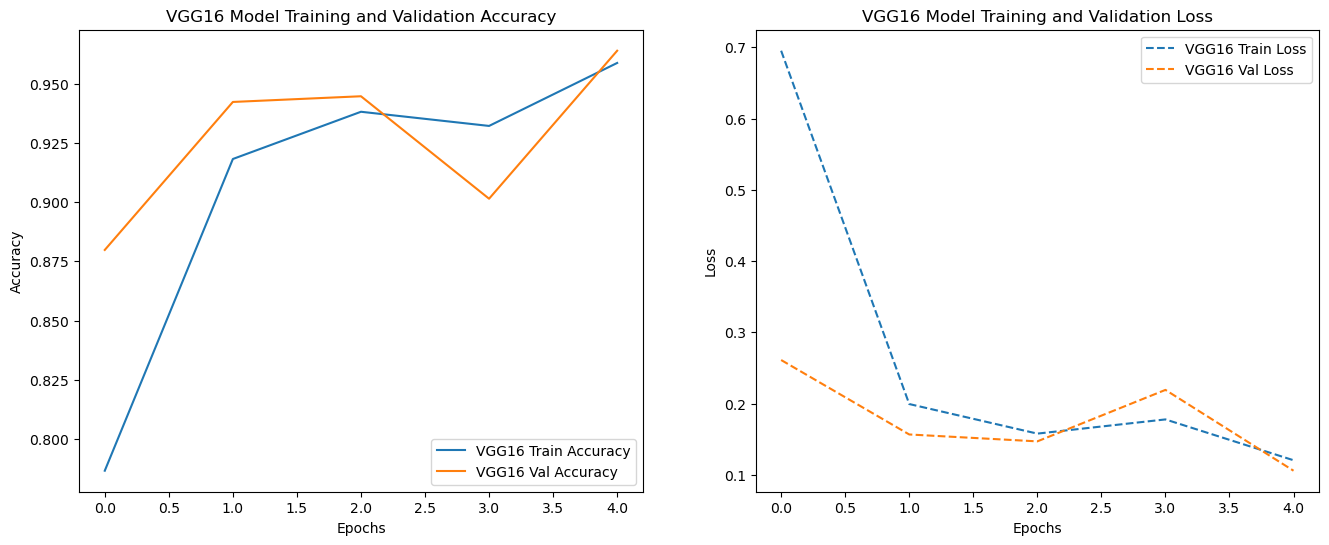

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plotting Accuracy
ax1.plot(vgg16_history.history['accuracy'], label='VGG16 Train Accuracy')
ax1.plot(vgg16_history.history['val_accuracy'], label='VGG16 Val Accuracy')
ax1.set_title('VGG16 Model Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')

# Plotting Loss
ax2.plot(vgg16_history.history['loss'], label='VGG16 Train Loss', linestyle='--')
ax2.plot(vgg16_history.history['val_loss'], label='VGG16 Val Loss', linestyle='--')
ax2.set_title('VGG16 Model Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')

# Display the plots
plt.show()

In [18]:
# Define and train VGG19 model
vgg19_base = VGG19(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), include_top=False, weights='imagenet')
vgg19_base.trainable = False

vgg19_model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    vgg19_base,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

vgg19_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

vgg19_history = vgg19_model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds)

vgg19_scores = vgg19_model.evaluate(test_ds)
print(f"VGG19 Test Accuracy: {vgg19_scores[1] * 100:.2f}%\n")

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 486s 10s/step - accuracy: 0.6176 - loss: 2.3616 - val_accuracy: 0.8558 - val_loss: 0.3774
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 499s 11s/step - accuracy: 0.8980 - loss: 0.2733 - val_accuracy: 0.9327 - val_loss: 0.2161
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 253s 5s/step - accuracy: 0.9104 - loss: 0.2370 - val_accuracy: 0.9447 - val_loss: 0.1696
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 191s 4s/step - accuracy: 0.9214 - loss: 0.1921 - val_accuracy: 0.9375 - val_loss: 0.2068
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 195s 4s/step - accuracy: 0.9247 - loss: 0.1824 - val_accuracy: 0.9351 - val_loss: 0.1461
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9539 - loss: 0.1302
VGG19 Test Accuracy: 94.53%



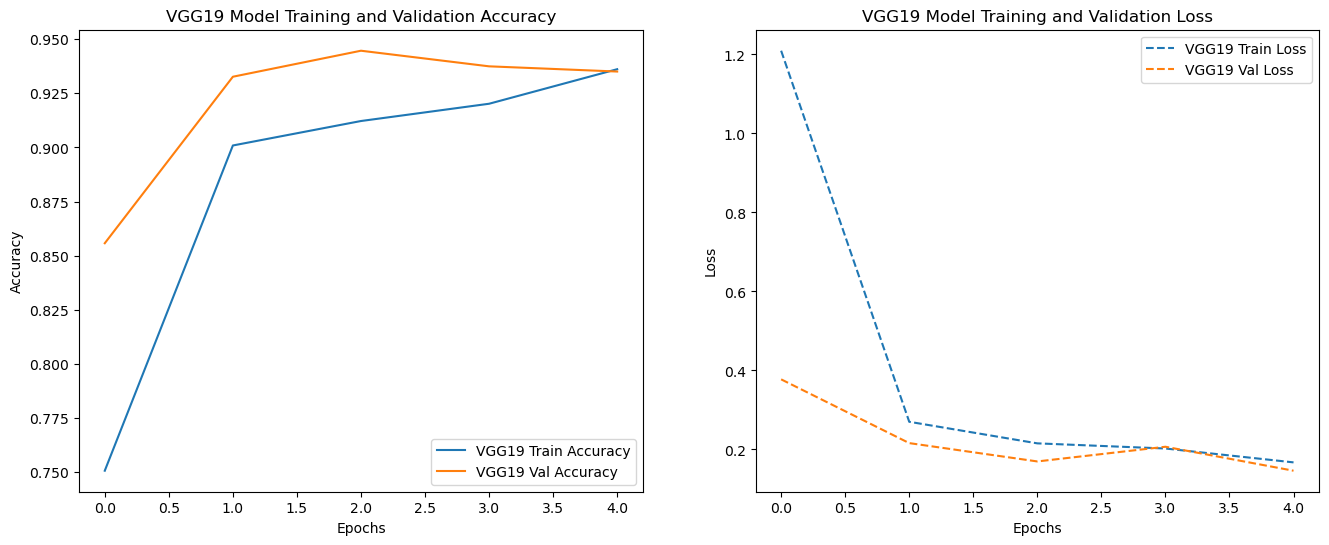

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plotting Accuracy
ax1.plot(vgg19_history.history['accuracy'], label='VGG19 Train Accuracy')
ax1.plot(vgg19_history.history['val_accuracy'], label='VGG19 Val Accuracy')
ax1.set_title('VGG19 Model Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')

# Plotting Loss
ax2.plot(vgg19_history.history['loss'], label='VGG19 Train Loss', linestyle='--')
ax2.plot(vgg19_history.history['val_loss'], label='VGG19 Val Loss', linestyle='--')
ax2.set_title('VGG19 Model Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')

# Display the plots
plt.show()

In [ ]:
# Define and train ResNet50 model
resnet50_base = ResNet50(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), include_top=False, weights='imagenet')
resnet50_base.trainable = False

resnet50_model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    resnet50_base,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

resnet50_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

resnet50_history = resnet50_model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds)

resnet50_scores = resnet50_model.evaluate(test_ds)
print(f"ResNet50 Test Accuracy: {resnet50_scores[1] * 100:.2f}%\n")

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.4553 - loss: 4.4640 - val_accuracy: 0.4303 - val_loss: 1.0855
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step - accuracy: 0.4455 - loss: 1.0814 - val_accuracy: 0.4303 - val_loss: 1.0670
Epoch 3/5
18/47 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.4313 - loss: 1.0663

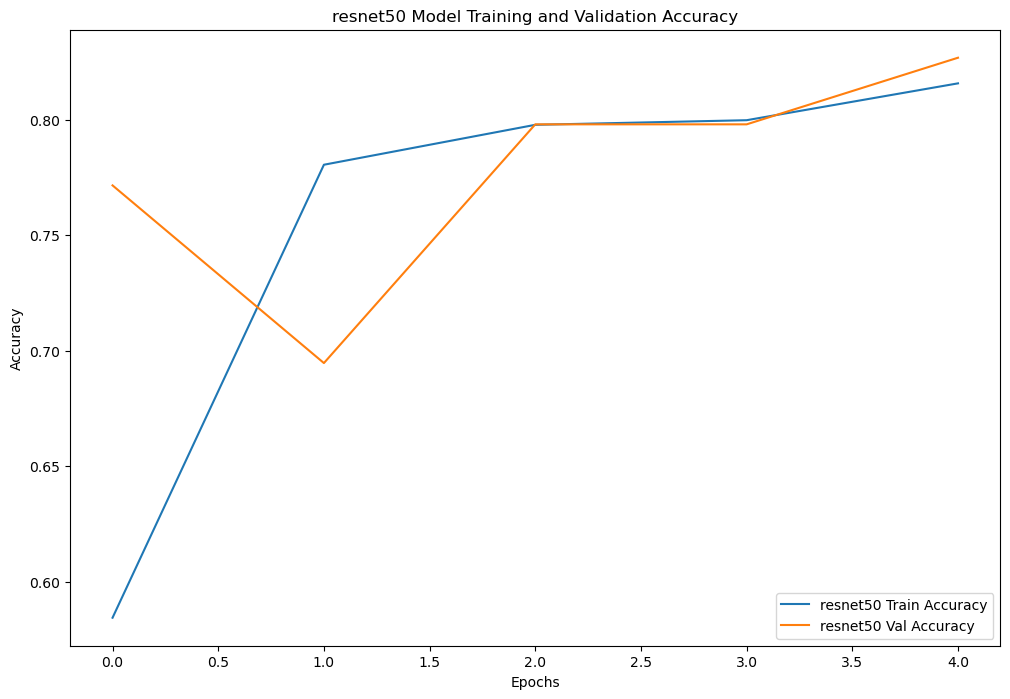

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plotting Accuracy
ax1.plot(resnet50_history.history['accuracy'], label='resnet50 Train Accuracy')
ax1.plot(resnet50_history.history['val_accuracy'], label='resnet50 Val Accuracy')
ax1.set_title('resnet50 Model Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')

# Plotting Loss
ax2.plot(resnet50_history.history['loss'], label='resnet50 Train Loss', linestyle='--')
ax2.plot(resnet50_history.history['val_loss'], label='resnet50 Val Loss', linestyle='--')
ax2.set_title('resnet50 Model Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')

# Display the plots
plt.show()

In [22]:
# Define and train InceptionV3 model
inceptionv3_base = InceptionV3(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), include_top=False, weights='imagenet')
inceptionv3_base.trainable = False

inceptionv3_model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    inceptionv3_base,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

inceptionv3_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

inceptionv3_history = inceptionv3_model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds)

inceptionv3_scores = inceptionv3_model.evaluate(test_ds)
print(f"InceptionV3 Test Accuracy: {inceptionv3_scores[1] * 100:.2f}%\n")

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.6267 - loss: 8.5798 - val_accuracy: 0.8918 - val_loss: 0.3420
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9177 - loss: 0.2365 - val_accuracy: 0.9303 - val_loss: 0.2163
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9437 - loss: 0.2122 - val_accuracy: 0.9159 - val_loss: 0.2595
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9380 - loss: 0.1770 - val_accuracy: 0.9447 - val_loss: 0.1696
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9525 - loss: 0.1444 - val_accuracy: 0.9279 - val_loss: 0.2186
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 750ms/step - accuracy: 0.9477 - loss: 0.1814
InceptionV3 Test Accuracy: 94.14%



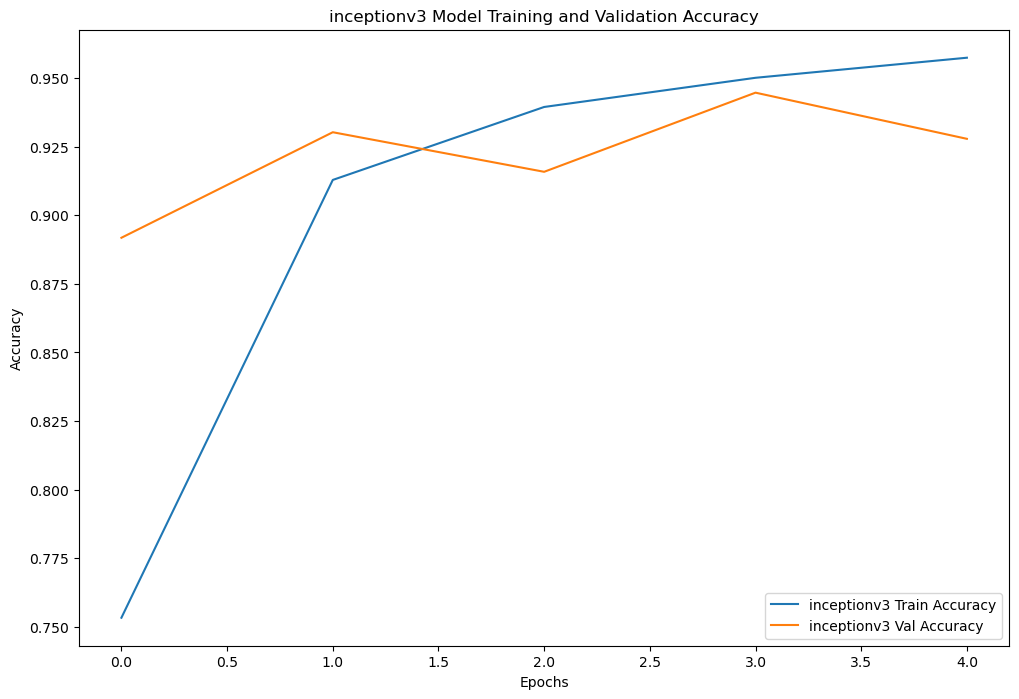

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plotting Accuracy
ax1.plot(inceptionv3_history.history['accuracy'], label='inceptionv3 Train Accuracy')
ax1.plot(inceptionv3_history.history['val_accuracy'], label='inceptionv3 Val Accuracy')
ax1.set_title('inceptionv3 Model Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')

# Plotting Loss
ax2.plot(inceptionv3_history.history['loss'], label='inceptionv3 Train Loss', linestyle='--')
ax2.plot(inceptionv3_history.history['val_loss'], label='inceptionv3 Val Loss', linestyle='--')
ax2.set_title('inceptionv3 Model Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')

# Display the plots
plt.show()

In [23]:
# Define and train MobileNetV2 model
mobilenetv2_base = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), include_top=False, weights='imagenet')
mobilenetv2_base.trainable = False

mobilenetv2_model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    mobilenetv2_base,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

mobilenetv2_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

mobilenetv2_history = mobilenetv2_model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds)

mobilenetv2_scores = mobilenetv2_model.evaluate(test_ds)
print(f"MobileNetV2 Test Accuracy: {mobilenetv2_scores[1] * 100:.2f}%\n")

C:\Users\nvish\AppData\Local\Temp\ipykernel_7800\3384936461.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenetv2_base = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), include_top=False, weights='imagenet')


Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7292 - loss: 5.4289 - val_accuracy: 0.9615 - val_loss: 0.2375
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 46s 988ms/step - accuracy: 0.9475 - loss: 0.3565 - val_accuracy: 0.9519 - val_loss: 0.1715
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 46s 987ms/step - accuracy: 0.9744 - loss: 0.0949 - val_accuracy: 0.9736 - val_loss: 0.0667
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 45s 955ms/step - accuracy: 0.9773 - loss: 0.1129 - val_accuracy: 0.9615 - val_loss: 0.1351
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 45s 957ms/step - accuracy: 0.9855 - loss: 0.0490 - val_accuracy: 0.9736 - val_loss: 0.1528
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 691ms/step - accuracy: 0.9591 - loss: 0.2384
MobileNetV2 Test Accuracy: 95.70%



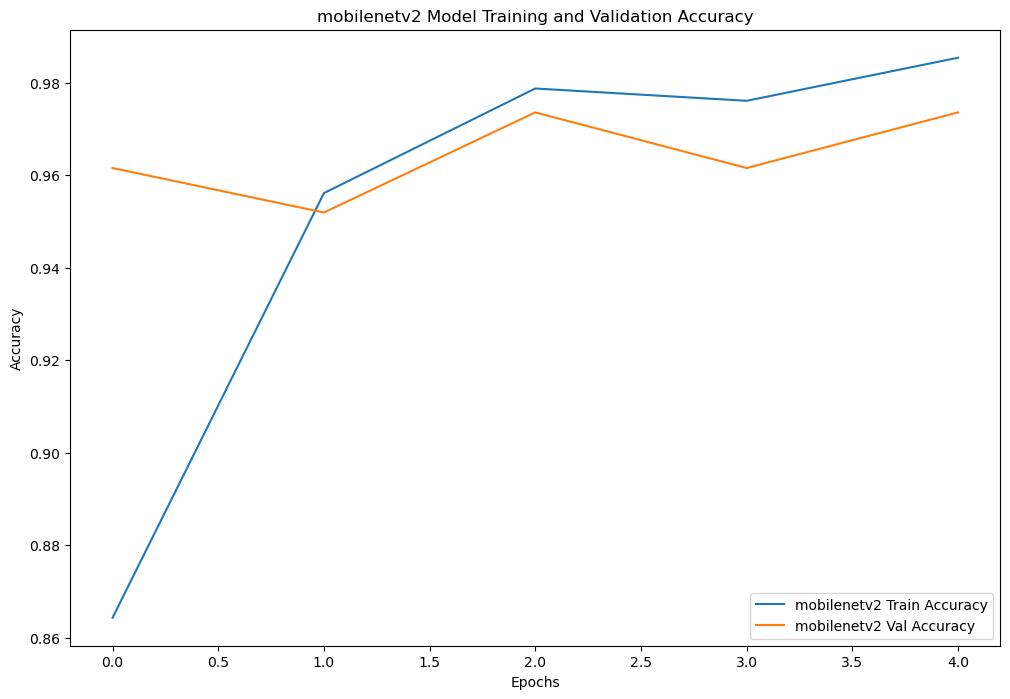

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plotting Accuracy
ax1.plot(mobilenetv2_history.history['accuracy'], label='mobilenetv2 Train Accuracy')
ax1.plot(mobilenetv2_history.history['val_accuracy'], label='mobilenetv2 Val Accuracy')
ax1.set_title('mobilenetv2 Model Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')

# Plotting Loss
ax2.plot(mobilenetv2_history.history['loss'], label='mobilenetv2 Train Loss', linestyle='--')
ax2.plot(mobilenetv2_history.history['val_loss'], label='mobilenetv2 Val Loss', linestyle='--')
ax2.set_title('mobilenetv2 Model Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')

# Display the plots
plt.show()

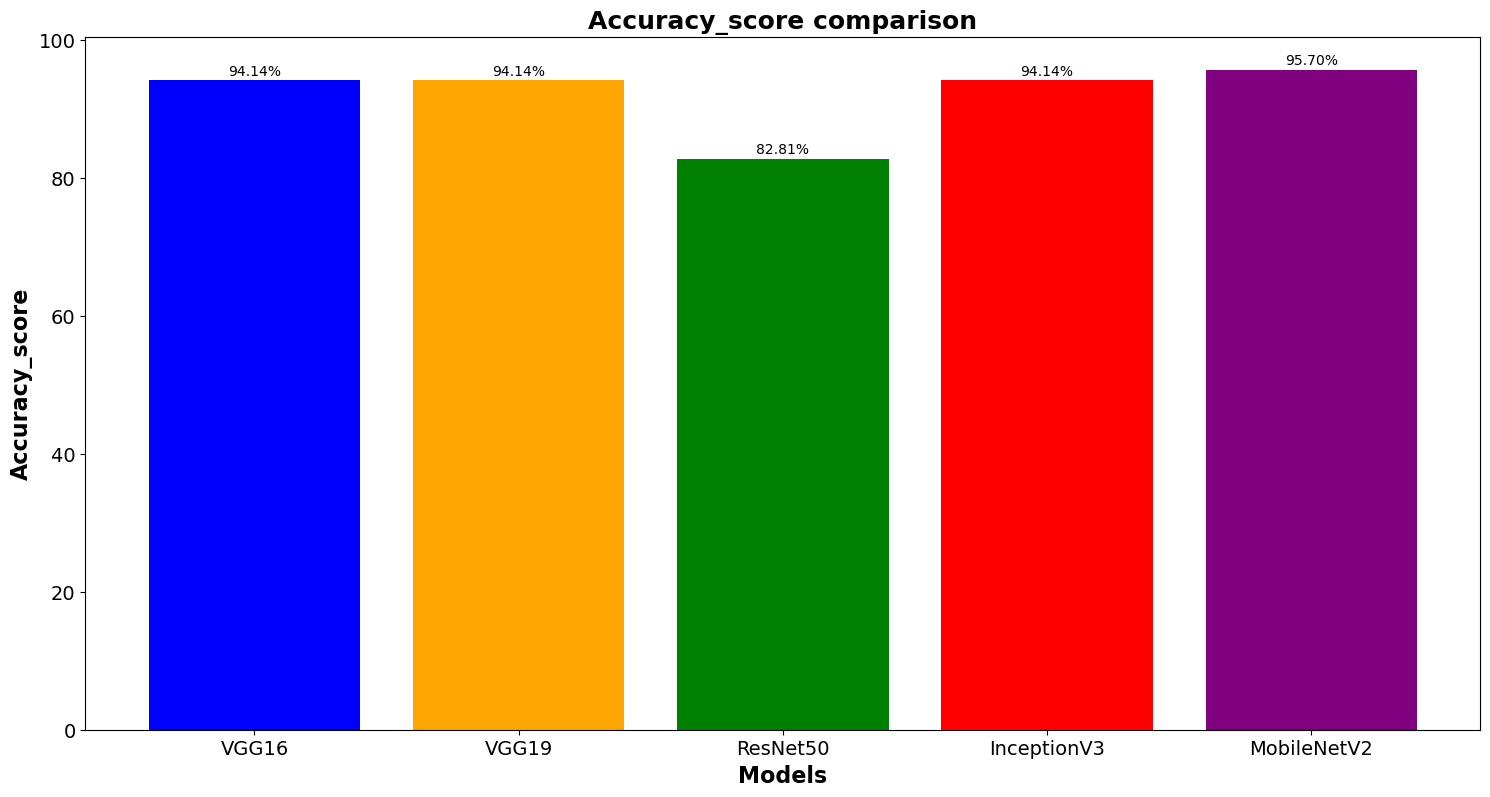

In [38]:
plt.figure(figsize=(18,9))
models=['VGG16','VGG19','ResNet50','InceptionV3','MobileNetV2']
accuracy=[vgg16_scores[1]*100,vgg19_scores[1] * 100,resnet50_scores[1] * 100,inceptionv3_scores[1] * 100,mobilenetv2_scores[1] * 100]
bars = plt.bar(models, accuracy, color=['blue', 'orange', 'green', 'red', 'purple'])
for bar, acc in zip(bars, accuracy):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3, f'{acc:.2f}%', ha='center', va='bottom')
plt.xlabel("Models",fontsize=16, fontweight='bold')
plt.ylabel("Accuracy_score",fontsize=16, fontweight='bold')
plt.title("Accuracy_score comparison",fontsize=18, fontweight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()